# Exploratory analysis take #1
The goal of this notebook is a first pass at analyzing the flight delay data from a single airport (PDX) from January 1, 2021 through September 30, 2025 at 00:00:00. I expect some of my methods to be less than perfectly efficient at this stage, but the main goal is to get a handle on what kind of data I have and how to analyze it. Some open questions I have are:

* How do I want to split the data? Stratified or purely random?
* Should I pull data from a longer stretch?
    * Note that I initially constrained this range due avoid interference from covid in the data and also to minimize the memory burden.
* Will this data eventually benefit from supplementation with weather data or is the accuracy already sufficient with just the historical delay data?

Some of these bullet points, namely the last one, will likely not be answered in this notebook, but I want to keep it in mind nonetheless.

In [127]:
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.metrics import root_mean_squared_error
from scipy.stats import randint

In [3]:
# Load all the PDX files
def load_flight_info(data_dir, pat_str):
    """
    Loads a single data frame containing all the data in data_dir with files matching the pat_str
    """
    df = pd.DataFrame()
    for entry in os.listdir(data_dir):
        # Construct full path
        full_path = os.path.join(data_dir, entry)

        # Check if it is actually a file and if it matches the pattern
        if os.path.isfile(full_path) and fnmatch.fnmatch(entry, pat_str):
            df = pd.concat([df, pd.read_csv(full_path, skiprows=7)])
            print(f'Loaded {full_path} added to dataframe.')

    return df

In [12]:
df = load_flight_info('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays', 'PDX*')

Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_AS_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_B6_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_DL_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_F9_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_G4_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_HA_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays\PDX_MQ_2_Delays.csv added to dataframe.
Loaded C:/Users/dloso/Documents/Data S

In [13]:
df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,G4,01/02/2024,742.0,290NV,AZA,10:08,10:12,160.0,152.0,4.0,10:24,12.0,0.0,0.0,0.0,0.0,0.0
1,G4,01/02/2024,1588.0,253NV,PVU,16:23,16:14,109.0,113.0,-9.0,16:30,16.0,0.0,0.0,0.0,0.0,0.0
2,G4,01/02/2024,3234.0,253NV,IDA,11:10,11:05,93.0,89.0,-5.0,11:17,12.0,0.0,0.0,0.0,0.0,0.0
3,G4,01/03/2022,9.0,247NV,IDA,11:13,12:16,92.0,83.0,63.0,12:28,12.0,39.0,0.0,0.0,0.0,15.0
4,G4,01/03/2023,76.0,218NV,IDA,19:17,21:05,91.0,96.0,108.0,21:17,12.0,0.0,0.0,5.0,0.0,108.0


# Segmenting out dates
Since my plan is, ultimately, to forecast delays given a carrier, date, and departure time, I do not necessarily care about the year in which the data took place for training purposes. I am going to split out the month and day into a new column and then the year into a separate column so that they may be viewed individually.

In [14]:
df['Date'] = pd.to_datetime(df['Date (MM/DD/YYYY)'])
df['DayOfYear'] = df['Date'].dt.dayofyear
# df['DepartureTimeHH'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.hour
df['DepartureTimeHour'] = pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.hour + pd.to_datetime(df['Scheduled departure time'], format='%H:%M').dt.minute / 60
df[['Date', 'DayOfYear', 'DepartureTimeHour']].head()

,Date,DayOfYear,DepartureTimeHour
0,2024-01-02,2.0,10.133333
1,2024-01-02,2.0,16.383333
2,2024-01-02,2.0,11.166667
3,2022-01-03,3.0,11.216667
4,2023-01-03,3.0,19.283333


# Dropping na values
We will drop na rows for Departure delay (Minutes) since there are only 9 of them. I would consider other filling methods for these na values if there were more of them. In this case, I would expect the impact of missing data to be minimal.

In [15]:
print(f'There are {df['Departure delay (Minutes)'].isna().sum()} na items in the departure delay column.')
df.dropna(subset='Departure delay (Minutes)', inplace=True)
print(f'Now we have dropped these na items so there are now {df['Departure delay (Minutes)'].isna().sum()} na items in the departure delay column.')

There are 15 na items in the departure delay column.
Now we have dropped these na items so there are now 0 na items in the departure delay column.


# Checking correlations
Determining the attributes to use in our model will take two approaches: (1) correlation matrices and (2) grouped means/standard deviations. Correlation matrices will take care of continuous variables, but for categorical ones, I will compare the means (with standard deviations) of the departure delay when grouped by carrier code and destination airport. If there are large variations with either of these, then they will make useful predictive additions to the model.

There is very little to no correlation of the departure delay with day or time, which follows given PDX's relatively stable weather. While there is a slight donward trend for delay times at increasing departure hours, that is likely driven by the large number of flights leaving earlier in the day, which can be seen in the histogram farther down this notebook. In contrast, we see large variations in the average departure delays for different carriers and destination airports. For the purposes of this project, I will still include all of these attributes in the model as they will come in handy when the model is expanded to other airports where variations in weather throughout the year will likely cause delays.

In [17]:
# numeric correlations
corr_matrix = df[['Departure delay (Minutes)', 'DayOfYear', 'DepartureTimeHour']].corr()
print(corr_matrix['Departure delay (Minutes)'].sort_values(ascending=False))

# categorical "correlations"
avg_carrier_code = df.groupby('Carrier Code')['Departure delay (Minutes)'].mean()
avg_dest_airport = df.groupby('Destination Airport')['Departure delay (Minutes)'].mean()

print(avg_carrier_code.sort_values(ascending=False))
print(avg_dest_airport.sort_values(ascending=False))

Departure delay (Minutes)    1.000000
DepartureTimeHour            0.148859
DayOfYear                    0.017188
Name: Departure delay (Minutes), dtype: float64
Carrier Code
B6    40.025189
G4    18.099383
AA    17.345201
HA    15.790855
F9    15.297292
WN    14.286974
NK    11.203267
OO     4.951658
DL     4.858814
AS     3.693164
QX     2.567731
MQ    -0.901099
YV    -1.043478
Name: Departure delay (Minutes), dtype: float64
Destination Airport
PBI    94.000000
IDA    30.869301
PDX    23.962422
DSM    23.597345
CVG    23.157895
         ...    
PAE     1.301980
SBP     1.294788
BIL     1.065637
FCA    -0.710227
FNT    -1.133333
Name: Departure delay (Minutes), Length: 111, dtype: float64


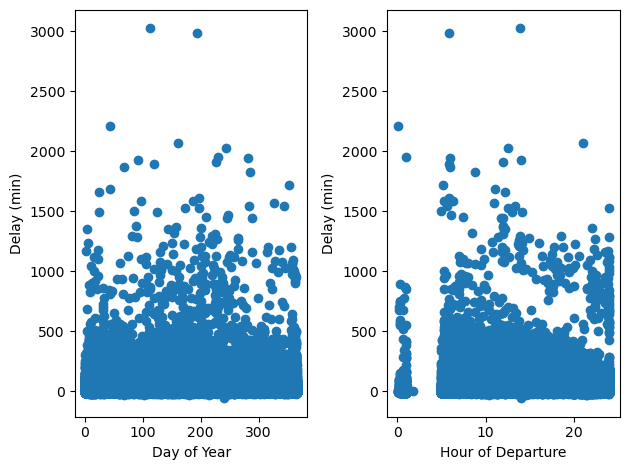

In [18]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(df['DayOfYear'], df['Departure delay (Minutes)'])
ax[0].set_ylabel('Delay (min)')
ax[0].set_xlabel('Day of Year')

ax[1].scatter(df['DepartureTimeHour'], df['Departure delay (Minutes)'])
ax[1].set_ylabel('Delay (min)')
ax[1].set_xlabel('Hour of Departure')

fig.tight_layout()

# Removing unused columns
Now I will drop columns that are not directly being used in the analysis. I may come back to some of these in future iterations (e.g. the different delay breakdowns), but at the moment, they merely serve to clutter the dataframe and analysis. This analysis will keep the columns for the departure delay, day of the year, departure time, carrier code, and destination airport.

In [20]:
df = df[['Departure delay (Minutes)', 'DayOfYear', 'DepartureTimeHour', 'Carrier Code', 'Destination Airport']]

# also drop the source item that made it through this whole analysis
df = df[df['Carrier Code'] != ' SOURCE: Bureau of Transportation Statistics']

# Splitting the data
Now I want to split the data up into training, cross validation, and test sets. Before that, I would like to consider how to split the data. Is it enough to simply split it into random units, or will that lead to underrepresentation of some of the data (e.g. some carriers be left out of the training/cv/test sets)? I will examine this issue through a quick look at a histogram of data by dates, scheduled departure times, carrier codes, and destination airports.

Looking at the histograms below, while the day of the year and scheduled hour of departure have relatively flat distributions, it appears that the departure delay, carrier code, and destination airport all show strongly skewed distributions of counts. To ensure our data sets are all nicely distributed relative to the real data, we will use a stratified split.

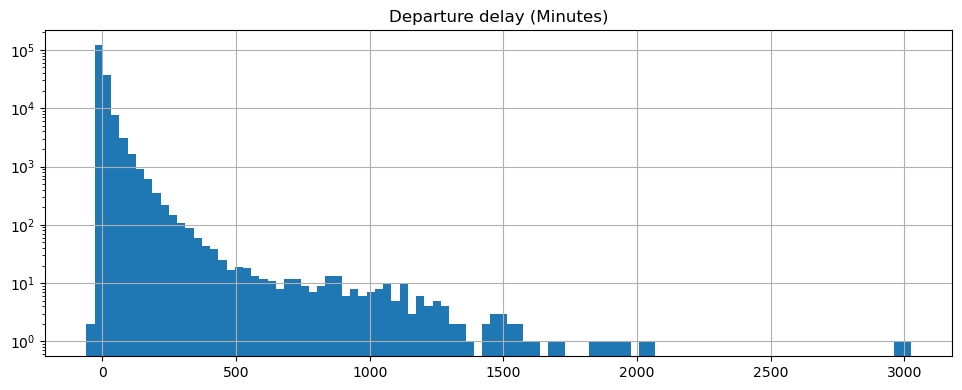

In [10]:
df.hist(column=['Departure delay (Minutes)'], figsize=(10, 4), bins=100)
plt.tight_layout()
plt.yscale('log')
plt.show()

In [27]:
# create bins for the delay times to ease the process of a stratified split
df['delay_cat'] = pd.cut(df['Departure delay (Minutes)'],
                         bins=[-np.inf, 0., 25., 50., 100., 500., np.inf],
                         labels=[1, 2, 3, 4, 5, 6])

df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['delay_cat'])
df_train.drop(['delay_cat'], axis=1, inplace=True)
df_test.drop(['delay_cat'], axis=1, inplace=True)

# Encoding and scaling data
With the attributes chosen, we must now encode the categorical variables and also scale the numerical ones. The categorical variables are handled simply enough with the OneHotEncoder, but the numerical variables will require different approaches for each. The delay times are quite skewed so we will take a three step approach: (1) make the values positive, (2) log transform them, (3) shift them to be centered and scaled aobut the median value. Meanwhile, we want to ensure that the cyclical nature of the departure time and departure day of the year are adequately captured by our model. We want 23:00 to be treated very similarly to 00:00 and similarly for day 1 and day 365. Trigonometric transforms with periods of 24 hours and 365 days, respectively, will solve those issues nicely for us.

In [72]:
# Set up log transform, inverse, and pipeline
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.log(X)

    def inverse_transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.exp(X)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_log' for col in input_features]

class ExpTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.exp(X)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_exp' for col in input_features]

# log_transformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, validate=True)

# MinMaxScaler to ensure data is all positive
pos_scaler = MinMaxScaler(feature_range=(0.1, 1.1))

# Scale by the median and interquartile range
robust_scaler = RobustScaler()

# standard scaler
std_scaler = StandardScaler()

delay_scale_pipeline = Pipeline([
    ('positive_scale', pos_scaler),
    ('log_scale', LogTransformer()),
    ('robust_scale', robust_scaler)
])

In [73]:
# sine and cosine transformer classes to be used for date and time variables
class SinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.sin(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_sin' for col in input_features]

class CosTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=1):
        self.period = period

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        return np.cos(2*np.pi * X / self.period)

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            # Use feature_names_in_ if available (set during fit)
            input_features = getattr(self, "feature_names_in_", [f'x{i}' for i in range(self.n_features_in_)])

        # Define how feature names are transformed
        return [f'{col}_cos' for col in input_features]

In [74]:
# one hot encoder for the categorical values
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

cat_pipeline = Pipeline([
    ('encoder', one_hot_encoder)
])

In [75]:
# Now set up which attributes get which transforms using a ColumnTransformer
time_attribs = ['DepartureTimeHour']
date_attribs = ['DayOfYear']
cat_attribs = ['Carrier Code', 'Destination Airport']

cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('categorical', one_hot_encoder, cat_attribs),
        ('day_sin', SinTransformer(period=365), date_attribs),
        ('day_cos', CosTransformer(period=365), date_attribs),
        ('hour_sin', SinTransformer(period=24), time_attribs),
        ('hour_cos', CosTransformer(period=24), time_attribs),
])

# Training a model
We are working on a prediction model featuring a number of attributes that may not contribute significantly to the model's predictive power (at least in this iteration without weather data) so a random forest model is a good choice.

In [113]:
df_labels = pd.DataFrame({'Departure delay (Minutes)': df_train['Departure delay (Minutes)'].copy()})
df_labels_transformed =  delay_scale_pipeline.fit_transform(df_labels)
df_features = df_train.drop('Departure delay (Minutes)', axis=1)

forest_reg = Pipeline([
    ('data_transformer', cyclic_cossin_transformer),
    ('random_forest', RandomForestRegressor(max_depth=6, n_jobs=-2))
])
forest = forest_reg.fit(df_features, df_labels_transformed.ravel())

In [77]:
# Use the name given in the 'steps' list ('preprocessor' in this case)
feature_names = forest_reg.named_steps['data_transformer'].get_feature_names_out()

# 6. Get the feature importances from the regressor step
# Use the name given in the 'steps' list ('regressor' in this case)
importances = forest_reg.named_steps['random_forest'].feature_importances_

# 7. Create a pandas Series for easy viewing and sorting
feature_importances_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importances_series[:15])

hour_sin__DepartureTimeHour_sin         0.348577
categorical__Carrier Code_WN            0.281972
day_cos__DayOfYear_cos                  0.164749
hour_cos__DepartureTimeHour_cos         0.098665
day_sin__DayOfYear_sin                  0.041943
categorical__Carrier Code_AA            0.020543
categorical__Carrier Code_B6            0.019868
categorical__Carrier Code_F9            0.009281
categorical__Carrier Code_HA            0.003368
categorical__Destination Airport_HNL    0.001794
categorical__Destination Airport_DFW    0.000982
categorical__Destination Airport_JFK    0.000927
categorical__Destination Airport_EWR    0.000838
categorical__Destination Airport_ECP    0.000658
categorical__Carrier Code_NK            0.000567
dtype: float64


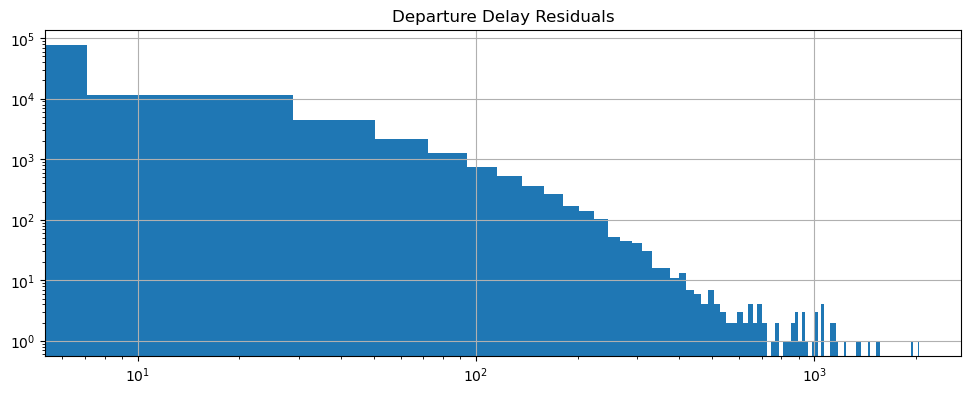

In [125]:
df_labels_test = pd.DataFrame({'Departure delay (Minutes)': df_test['Departure delay (Minutes)'].copy()})
df_features_test = df_test.drop('Departure delay (Minutes)', axis=1)

pred = delay_scale_pipeline.inverse_transform(forest_reg.predict(df_features_test).reshape(-1,1))
delay_rmse = root_mean_squared_error(pred, df_labels_test)
delay_residuals = df_labels_test - pred
delay_residuals.hist(figsize=(10, 4), bins=100)
plt.title('Departure Delay Residuals')
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

# Cross-validation
To focus in on the performance of this model, let's use 10-fold cross-validation. This will give us an idea of the effectiveness of the model as well as its variability given different training data.

It appears that our average error is 28 minutes across all the folds with very little variation between them (standard deviation of less than 1/2 a minute). Combined with the histogram of departure delay residuals from above (for only a single fold), it seems that our model produces most of its errors in the 0 to 100 minute range with some larger errors corresponding to the outliers in the data. We may be able to pull down the average error through some hyperparameter tuning.

In [116]:
tree_rmses = -cross_val_score(forest_reg, df_features, df_labels_transformed.ravel(), scoring='neg_root_mean_squared_error', cv=10)

In [120]:
pd.Series((delay_scale_pipeline.inverse_transform(tree_rmses.reshape(-1,1))).reshape(-1)).describe()

count    10.000000
mean     28.418196
std       0.473675
min      27.722888
25%      28.128167
50%      28.313275
75%      28.712246
max      29.188432
dtype: float64

# Hyper-parameter tuning
Let's take a look at varying the max_features, max_depth, and n_estimators to see if we can improve the performance of our model. We'll use the RandomizedSearchCV for this to sample the space more effectively.

In this case, the hyperparameter tuning does not seem to contribute to any meaningfully improved results in terms of the rmse. The feature importances give some hints to this. It is chiefly the time of day and the day of the year that are influencing the delay time estimates. Carrier codes and airports initially appear to factor in, but these line up with the most frequent of each catergory, likely because these are given the most chances to be delayed. That is, having more flights to SEA does not give more chances to be not-delayed, but rather only gives additional chances to be delayed, which is what the model can see.

In [131]:
param_distribs = {'random_forest__max_features': randint(low=2, high=20),
                  'random_forest__max_depth': randint(low=5, high=15),
                  'random_forest__n_estimators': randint(low=10, high=250)}
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, 
                                n_iter=10, cv=3, scoring='neg_root_mean_squared_error')
rnd_search.fit(df_features, df_labels_transformed.ravel())

,estimator,Pipeline(step... n_jobs=-2))])
,param_distributions,"{'random_forest__max_depth': <scipy.stats....0020E2E471B80>, 'random_forest__max_features': <scipy.stats....0020E2B16F450>, 'random_forest__n_estimators': <scipy.stats....0020E2E472120>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


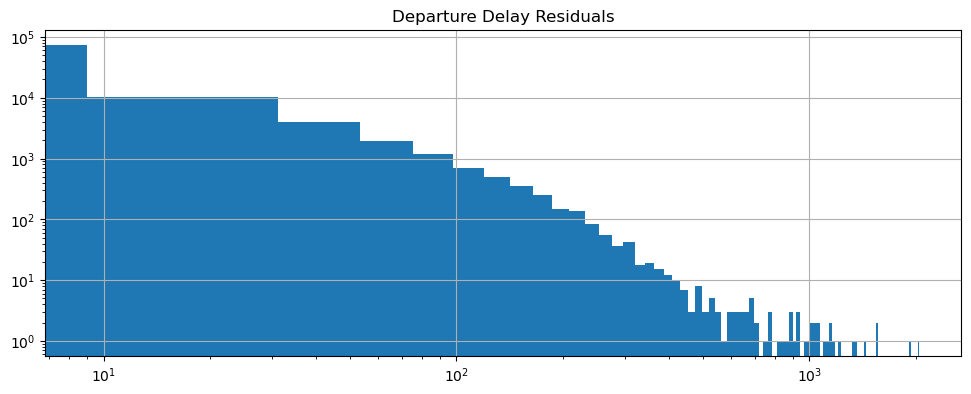

In [134]:
best_model = rnd_search.best_estimator_
df_labels_test = pd.DataFrame({'Departure delay (Minutes)': df_test['Departure delay (Minutes)'].copy()})
df_features_test = df_test.drop('Departure delay (Minutes)', axis=1)

pred = delay_scale_pipeline.inverse_transform(best_model.predict(df_features_test).reshape(-1,1))
delay_rmse = root_mean_squared_error(pred, df_labels_test)
delay_residuals = df_labels_test - pred
delay_residuals.hist(figsize=(10, 4), bins=100)
plt.title('Departure Delay Residuals')
plt.tight_layout()
plt.yscale('log')
plt.xscale('log')
plt.show()

In [141]:
feature_importances = (best_model['random_forest'].feature_importances_).round(2)
pd.DataFrame(sorted(zip(feature_importances,
           best_model['data_transformer'].get_feature_names_out()),
       reverse=True)).head(10)

,0,1
0,0.26,hour_sin__DepartureTimeHour_sin
1,0.20,day_cos__DayOfYear_cos
2,0.17,day_sin__DayOfYear_sin
3,0.13,hour_cos__DepartureTimeHour_cos
4,0.09,categorical__Carrier Code_WN
5,0.03,categorical__Carrier Code_QX
6,0.03,categorical__Carrier Code_AS
7,0.02,categorical__Carrier Code_OO
8,0.01,categorical__Destination Airport_SEA
9,0.01,categorical__Carrier Code_DL


In [148]:
df['Destination Airport'].value_counts(), df['Carrier Code'].value_counts()

(Destination Airport
 SEA    37410
 PHX    29761
 LAS    29511
 LAX    28410
 DEN    25883
        ...  
 BUF       27
 PVD       26
 CRP        9
 PBI        5
 CLE        1
 Name: count, Length: 111, dtype: int64,
 Carrier Code
 WN    353691
 AS     77579
 QX     52155
 OO     45323
 DL     31370
 AA     16544
 NK      5264
 F9      5244
 HA      3543
 G4      1620
 B6      1588
 MQ       182
 YV        23
 Name: count, dtype: int64)

# Closing thoughts and next steps
This first attempt does not give much promising in the way of estimating flight delays. An average error of 38 minutes tells us next to nothing about a flight's likely delay time, especially when the standard deviation of delay times is 39.7 minutes. What can we change? 
* Is a random forest regressor the right choice of model?
    * We could be better served by a categorizer that determines if a flight will be dalayed or not rather than an estimate of the precise delay.
* Are all of the attributes actually useful in this model?
    * We can likely remove the destination airport and carrier codes to speed up model training and evaluation.
* Does this generalize well to larger datasets? What about additional airports?
    * It is possible that PDX is a strange microcosm of the US flight world in which estimating delays from this data is difficult or impossible. Looking at a broader range of origin airports could provide us access to more meaningful trends.
* Did we overfit? Underfit?
    * Plotting some learning curves would give us some nice insight to this issue.
* Is there other data that could be useful here?
    * While some flights are delayed due to issues like late cabin crews, which we don't have easily accessible data for, many flights are delayed due to weather. We could pull weather data for the origin and destination airports to correlate weather quality with delay time.